# LGBMRegressor를 이용한 삼성전자의 다음날 종가&상승or하락 예측

1990년 1월 1일부터 2022년 12월 31일의 데이터로 2023년의 삼성전자 주가를 예측합니다.

In [ ]:
!pip install finance-datareader

FinanceDataReader 라이브러리로 1990년 1월 1일부터 2023년 8월 4일까지의 삼성전자 주가 데이터를 불러옵니다.

먼저, 직전 몇 거래일 동안의 데이터로 다음날 종가를 예측할지 결정합니다.
<br>
<br>
이를 위해, 5~200일 중 가장 결정계수 값이 높은 수를 찾습니다.

35개의 직전 거래일 데이터를 사용하는 것이 가장 결정계수값이 높았습니다.
<br>
<br>
이제 모델을 학습해보겠습니다.

In [ ]:
import pandas as pd
import FinanceDataReader as fdr

# 종목 코드 설정
symbol_list = {
    # 'NASDAQ': '^IXIC',
    # 'S&P500': '^GSPC',
    # 'Dow Jones': '^DJI',
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Alphabet A': 'GOOGL',
    'Amazon': 'AMZN',
    'Berkshire Hathaway': 'BRK-A',
    'NVIDIA': 'NVDA',
    'Meta Platforms': 'META',
    'Tesla': 'TSLA',
    'Visa': 'V',
    'UnitedHealth Group': 'UNH'
    # 'Alphabet C': 'GOOG',
    # 'Procter & Gamble': 'PG',
    # 'The Home Depot': 'HD',
    # 'Mastercard': 'MA',
    # 'JPMorgan Chase': 'JPM',
    # 'Goldman Sachs': 'GS',
    # 'Intel': 'INTC',
    # 'Walmart': 'WMT',
    # 'Merck': 'MRK',
    # 'IBM': 'IBM',
    # '3M': 'MMM',
    # 'Johnson & Johnson': 'JNJ',
    # 'Exxon Mobil': 'XOM',
    # 'AT&T': 'T',
    # 'Pfizer': 'PFE',
    # 'Coca-Cola': 'KO',
    # 'Boeing': 'BA'
}

all_data = {name: fdr.DataReader(code) for name, code in symbol_list.items()}

In [ ]:
# apple_data = all_data['NASDAQ']
# print(apple_data.head())

In [ ]:
import numpy as np

def preprocess_stock_data(df):
    df = df.copy()

    df['Next_Day_Direction'] = df['Close'].shift(-1) - df['Close']

    # 'Next_Day_Direction' 값을 '상승', '하락'으로 변환
    df['Next_Day_Direction'] = df['Next_Day_Direction'].apply(lambda x: 1 if x >= 0 else 0)
    df = df.iloc[:-1]


    # 이동평균을 계산하는 함수를 정의합니다.
    def calculate_moving_average(df, column, window):
        return df[column].rolling(window=window).mean()

    # 여러 이동평균 기간을 설정합니다.
    moving_average_periods = [5, 10, 20, 60, 120, 240]

    # 이동평균을 구하고 데이터 프레임에 새 열로 추가합니다.
    for period in moving_average_periods:
        column_name = f"MA_{period}"
        df[column_name] = calculate_moving_average(df, 'Close', period)


        # 이동표준편차를 계산하는 함수를 정의합니다.
    def calculate_moving_std(df, column, window):
        return df[column].rolling(window=window).std()

    # 볼린저 밴드를 계산하는 함수를 정의합니다.
    def calculate_bollinger_bands(df, column, window):
        MA = calculate_moving_average(df, column, window)
        STD = calculate_moving_std(df, column, window)
        return MA - 2 * STD, MA + 2 * STD

    # 볼린저 밴드 기간을 설정합니다.
    bollinger_band_period = 20

    # 볼린저 밴드를 계산합니다.
    df['BB_Lower'], df['BB_Upper'] = calculate_bollinger_bands(df, 'Close', bollinger_band_period)


        # RSI를 계산하는 함수를 정의합니다.
    def calculate_rsi(df, column, window=14):
        delta = df[column].diff()
        gain, loss = delta.copy(), delta.copy()
        gain[gain < 0] = 0
        loss[loss > 0] = 0

        # Wilder's exponential moving average
        avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
        avg_loss = abs(loss.ewm(com=window - 1, min_periods=window).mean())

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        return rsi

    # RSI 기간을 설정합니다. 일반적으로 14일을 사용합니다.
    rsi_period = 14

    # RSI를 계산합니다.
    df['RSI'] = calculate_rsi(df, 'Close', rsi_period)

    # # 지수이동평균(EMA)을 계산하는 함수를 정의합니다.
    # def calculate_ema(df, column, window):
    #     return df[column].ewm(span=window).mean()

    # # MACD를 계산하는 함수를 정의합니다.
    # def calculate_macd(df, column, short_window=12, long_window=26):
    #     short_ema = calculate_ema(df, column, short_window)
    #     long_ema = calculate_ema(df, column, long_window)
    #     return short_ema - long_ema

    # # MACD 시그널을 계산하는 함수를 정의합니다.
    # def calculate_macd_signal(df, column, macd_window=9):
    #     return df[column].ewm(span=macd_window).mean()

    # # MACD를 계산합니다.
    # df['MACD'] = calculate_macd(df, 'Close')

    # # MACD 시그널을 계산합니다.
    # df['MACD_Signal'] = calculate_macd_signal(df, 'MACD')


    # # True Range를 계산하는 함수를 정의합니다.
    # def calculate_true_range(df, high_col='High', low_col='Low', close_col='Close'):
    #     high_low = df[high_col] - df[low_col]
    #     high_close = df[high_col] - df[close_col].shift(1)
    #     low_close = df[low_col] - df[close_col].shift(1)
    #     ranges = pd.concat([high_low, high_close.abs(), low_close.abs()], axis=1)
    #     true_range = ranges.max(axis=1)
    #     return true_range

    # # +DMI, -DMI를 계산하는 함수를 정의합니다.
    # def calculate_dm(df, high_col='High', low_col='Low'):
    #     up_move = df[high_col] - df[high_col].shift(1)
    #     down_move = df[low_col].shift(1) - df[low_col]

    #     plus_dm = pd.Series(index=df.index, dtype='float64')
    #     minus_dm = pd.Series(index=df.index, dtype='float64')

    #     for i in range(len(df)):
    #         if up_move[i] > down_move[i] and up_move[i] > 0:
    #             plus_dm.iloc[i] = up_move[i]
    #         else:
    #             plus_dm.iloc[i] = 0
    #         if down_move[i] > up_move[i] and down_move[i] > 0:
    #             minus_dm.iloc[i] = down_move[i]
    #         else:
    #             minus_dm.iloc[i] = 0

    #     return plus_dm, minus_dm


    # # ADX를 계산하는 함수를 정의합니다.
    # def calculate_adx(df, window=14, high_col='High', low_col='Low', close_col='Close'):
    #     true_range = calculate_true_range(df)
    #     plus_dm, minus_dm = calculate_dm(df)

    #     atr = true_range.rolling(window=window).sum() / window
    #     plus_di = 100 * (plus_dm.rolling(window=window).sum() / atr)
    #     minus_di = 100 * (minus_dm.rolling(window=window).sum() / atr)

    #     dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    #     adx = dx.rolling(window=window).mean()

    #     return adx

    # # ADX를 계산합니다.
    # df['ADX'] = calculate_adx(df)

    # # 전환선 (Conversion Line)를 계산하는 함수를 정의합니다.
    # def calculate_conversion_line(df, high_col='High', low_col='Low', n1=9):
    #     high_n1 = df[high_col].rolling(window=n1).max()
    #     low_n1 = df[low_col].rolling(window=n1).min()
    #     conversion_line = (high_n1 + low_n1) / 2
    #     return conversion_line

    # # 기준선 (Base Line)를 계산하는 함수를 정의합니다.
    # def calculate_base_line(df, high_col='High', low_col='Low', n2=26):
    #     high_n2 = df[high_col].rolling(window=n2).max()
    #     low_n2 = df[low_col].rolling(window=n2).min()
    #     base_line = (high_n2 + low_n2) / 2
    #     return base_line

    # # 선행 스팬 A를 계산하는 함수를 정의합니다.
    # def calculate_leading_span_A(conversion_line, base_line):
    #     leading_span_A = (conversion_line + base_line) / 2
    #     return leading_span_A

    # # 선행 스팬 B를 계산하는 함수를 정의합니다.
    # def calculate_leading_span_B(df, high_col='High', low_col='Low', n3=52):
    #     high_n3 = df[high_col].rolling(window=n3).max()
    #     low_n3 = df[low_col].rolling(window=n3).min()
    #     leading_span_B = (high_n3 + low_n3) / 2
    #     return leading_span_B

    # # 전환선 (Conversion Line) 계산
    # df['Conversion_Line'] = calculate_conversion_line(df)

    # # 기준선 (Base Line) 계산
    # df['Base_Line'] = calculate_base_line(df)

    # # 선행 스팬 A 계산
    # df['Leading_Span_A'] = calculate_leading_span_A(df['Conversion_Line'], df['Base_Line'])

    # # 선행 스팬 B 계산
    # df['Leading_Span_B'] = calculate_leading_span_B(df)


    # 각 column에 0 몇개인지 확인
    for col in df.columns:
        missing_rows = df.loc[df[col]==0].shape[0]
        # print(col + ': ' + str(missing_rows))
    df['Volume'] = df['Volume'].replace(0, np.nan)
    df = df.dropna()
    df.isnull().sum()

    return df

In [ ]:
preprocessed_data = {name: preprocess_stock_data(df) for name, df in all_data.items()}

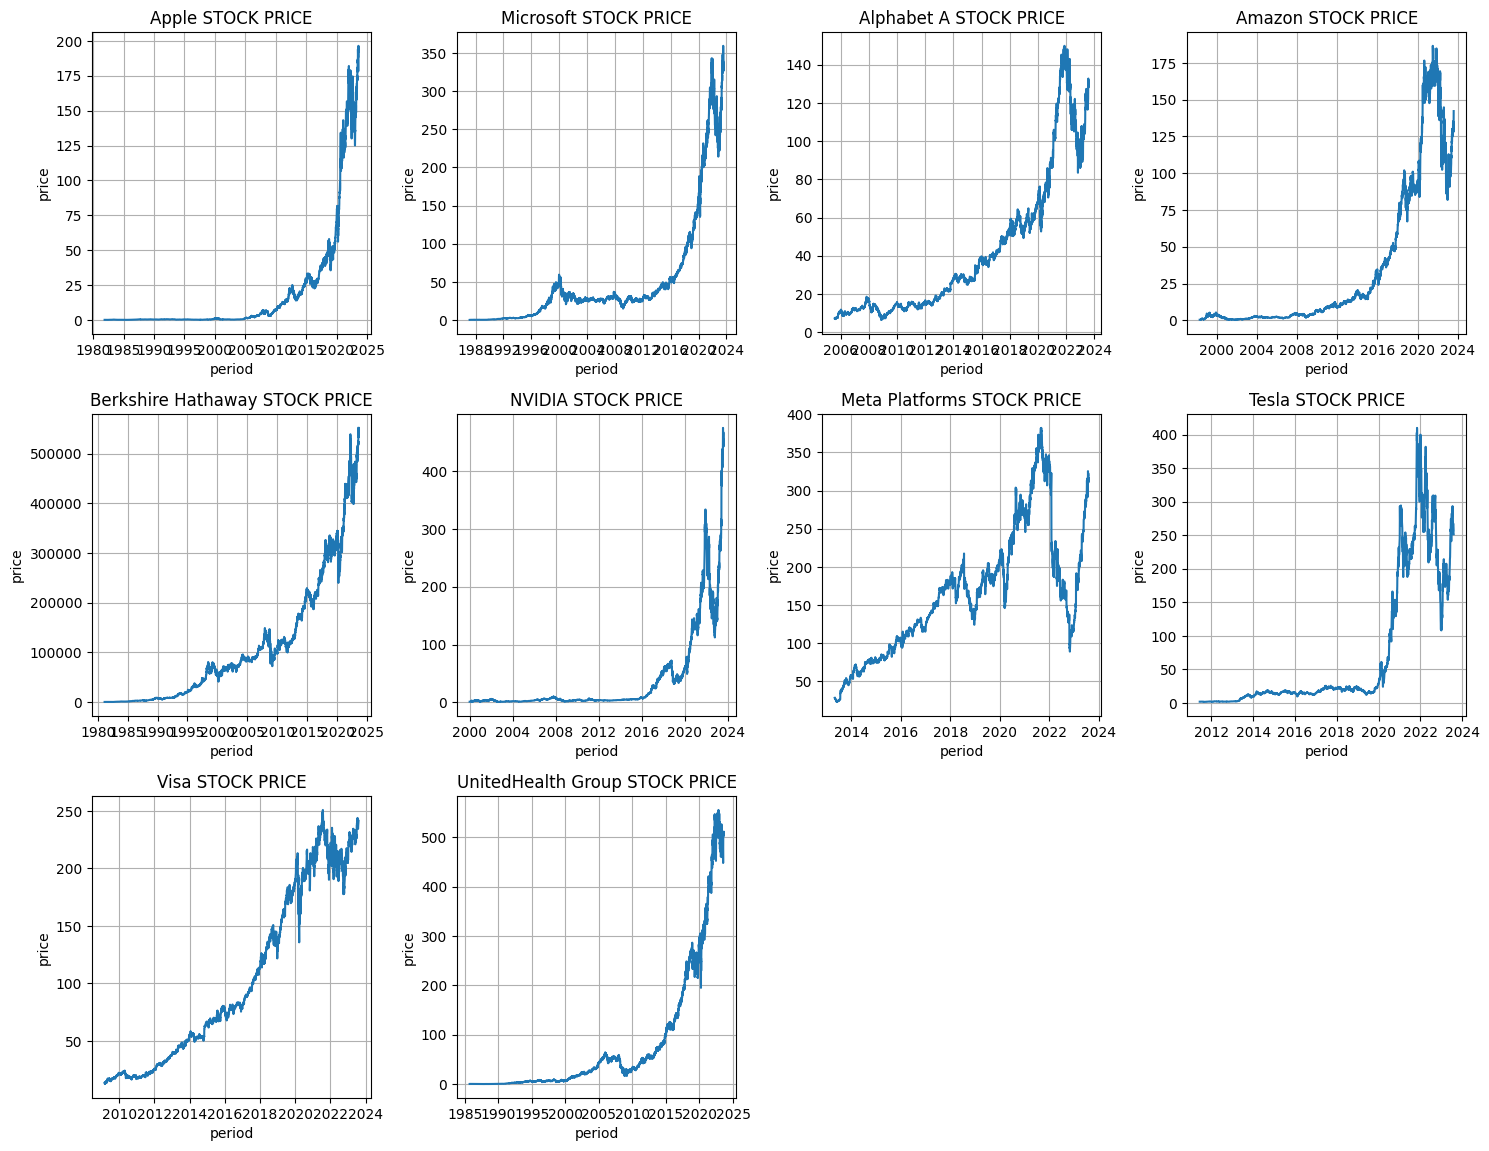

In [ ]:
import matplotlib.pyplot as plt

# 4x4 그리드 레이아웃을 사용하여 각 종목 차트를 표시합니다.
# nrows와 ncols는 골고루 결정
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for ax, (name, df) in zip(axes.flatten(), preprocessed_data.items()):
    ax.plot(df['Close'], label='Close')
    ax.set_title(name + ' STOCK PRICE')
    ax.set_ylabel('price')
    ax.set_xlabel('period')
    ax.grid()

# 사용하지 않는 서브플롯 제거
n_plots = len(preprocessed_data)
for i in range(n_plots, nrows * ncols):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])

    return np.array(x), np.array(y)

sequence_length = 50
scaler_dict = {}

for name in preprocessed_data:
    # 데이터 분리
    target_data = preprocessed_data[name]["Next_Day_Direction"]
    input_data = preprocessed_data[name].drop(columns=["Next_Day_Direction"])

    # Normalize the input data
    scaler = MinMaxScaler()
    input_data_normalized = scaler.fit_transform(input_data.values)
    scaler_dict[name] = scaler

    # Concatenate normalized input data and target data
    data = np.concatenate([input_data_normalized, target_data.values[:, np.newaxis]], axis=1)

    # Split the data into train and test sets
    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Create sequences
    x_train, y_train = create_sequences(train_data, sequence_length)
    x_test, y_test = create_sequences(test_data, sequence_length)

    preprocessed_data[name] = {
        "x_train": x_train,
        "y_train": y_train,
        "x_test": x_test,
        "y_test": y_test
    }

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(25, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

trained_models = {}

for name in preprocessed_data:
    print(f"{name} Processing")
    x_train = preprocessed_data[name]['x_train']
    y_train = preprocessed_data[name]['y_train']

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # Early Stopping
    checkpoint = ModelCheckpoint(name + ' best_model.h5', monitor='val_loss', save_best_only=True)  # Model Checkpoint

    lstm_model = create_lstm_model(x_train.shape[1:])
    lstm_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=5, callbacks=[early_stopping, checkpoint])
    trained_models[name] = lstm_model

    # Test the model on the test dataset
    print(len(x_test))
    test_accuracy = lstm_model.evaluate(x_test, y_test, verbose=0)[1]  # Get the 'accuracy' metric
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")

Apple Processing
Epoch 1/5
262/262 [==============================] - 11s 14ms/step - loss: 0.6916 - accuracy: 0.5285 - val_loss: 0.6955 - val_accuracy: 0.4591
Epoch 2/5
262/262 [==============================] - 2s 9ms/step - loss: 0.6914 - accuracy: 0.5322 - val_loss: 0.6938 - val_accuracy: 0.4989
Epoch 3/5
262/262 [==============================] - 3s 10ms/step - loss: 0.6912 - accuracy: 0.5340 - val_loss: 0.6917 - val_accuracy: 0.5339
Epoch 4/5
262/262 [==============================] - 2s 9ms/step - loss: 0.6914 - accuracy: 0.5327 - val_loss: 0.6920 - val_accuracy: 0.5339
Epoch 5/5
262/262 [==============================] - 3s 11ms/step - loss: 0.6911 - accuracy: 0.5318 - val_loss: 0.6938 - val_accuracy: 0.4887
1858
Apple Test Accuracy: 0.5339
Microsoft Processing
Epoch 1/5
229/229 [==============================] - 7s 12ms/step - loss: 0.6931 - accuracy: 0.5199 - val_loss: 0.7246 - val_accuracy: 0.4661
Epoch 2/5
229/229 [==============================] - 2s 9ms/step - loss: 0.691

In [ ]:
import FinanceDataReader as fdr

# Get XOM stock data
XOM_stock_data = fdr.DataReader('^GSPC')

# Preprocess the stock data
XOM_preprocessed_data = preprocess_stock_data(XOM_stock_data)
print(XOM_preprocessed_data['Next_Day_Direction'].value_counts())
# Normalize the input data
XOM_input_data = XOM_preprocessed_data.drop(columns=["Next_Day_Direction"])
scaler = MinMaxScaler()
XOM_input_data_normalized = scaler.fit_transform(XOM_input_data)
print(len(XOM_input_data_normalized))
# Concatenate normalized input data and target data
XOM_target_data = XOM_preprocessed_data["Next_Day_Direction"]
XOM_data = np.concatenate([XOM_input_data_normalized, XOM_target_data.values[:, np.newaxis]], axis=1)

# Create sequences
XOM_x, XOM_y = create_sequences(XOM_data, sequence_length)
print(len(XOM_x))

# Evaluate the trained models on the XOM data
model_accuracies = []
sum_acc = 0
for name, model in trained_models.items():
    print(f"Evaluating {name}")
    XOM_accuracy = model.evaluate(x=XOM_x, y=XOM_y, verbose=0)[1]
    model_accuracies.append((name, XOM_accuracy))
    sum_acc += XOM_accuracy
    print(f"{name} Test Accuracy on XOM: {XOM_accuracy:.4f}")

# Pick the model with the highest accuracy
best_model = max(model_accuracies, key=lambda x: x[1])
print(f"\nThe best model for XOM is {best_model[0]} with accuracy {best_model[1]:.4f}")
print(f"{sequence_length}개의 직전 거래일 데이터로 예측 / mean : {sum_acc / len(model_accuracies)}")

1    5739
0    5014
Name: Next_Day_Direction, dtype: int64
10753
10703
Evaluating Apple
Apple Test Accuracy on XOM: 0.5330
Evaluating Microsoft
Microsoft Test Accuracy on XOM: 0.4959
Evaluating Alphabet A
Alphabet A Test Accuracy on XOM: 0.5336
Evaluating Amazon
Amazon Test Accuracy on XOM: 0.5172
Evaluating Berkshire Hathaway
Berkshire Hathaway Test Accuracy on XOM: 0.5336
Evaluating NVIDIA
NVIDIA Test Accuracy on XOM: 0.5331
Evaluating Meta Platforms
Meta Platforms Test Accuracy on XOM: 0.5336
Evaluating Tesla
Tesla Test Accuracy on XOM: 0.5336
Evaluating Visa
Visa Test Accuracy on XOM: 0.5336
Evaluating UnitedHealth Group
UnitedHealth Group Test Accuracy on XOM: 0.5336

The best model for XOM is Alphabet A with accuracy 0.5336
50개의 직전 거래일 데이터로 예측 / mean : 0.5280855745077133
